In [47]:
import pandas as pd
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [40]:
img_names = os.listdir("./PennFudanPed/PNGImages")
img_names.sort()

imgname2imageid = {}
for idx, img_name in enumerate(img_names):
    imgname2imageid[img_name] = idx

In [41]:
f = open('./PennFudanPed/PennFudanPed_train.json',)
data = json.load(f)
df = pd.json_normalize(data['images'])
df

,file_name,height,width,id
0,PennFudanPed/PNGImages/PennPed00004.png,436,786,0
1,PennFudanPed/PNGImages/PennPed00085.png,341,403,1
2,PennFudanPed/PNGImages/FudanPed00048.png,559,585,2
3,PennFudanPed/PNGImages/PennPed00082.png,321,398,3
4,PennFudanPed/PNGImages/PennPed00094.png,349,422,4
...,...,...,...,...
115,PennFudanPed/PNGImages/PennPed00029.png,418,672,115
116,PennFudanPed/PNGImages/PennPed00016.png,399,683,116
117,PennFudanPed/PNGImages/FudanPed00029.png,404,435,117
118,PennFudanPed/PNGImages/FudanPed00065.png,411,504,118


In [98]:
df1 = pd.json_normalize(data["annotations"])
df1.head(20)

,area,iscrowd,bbox,category_id,image_id,id,ignore,segmentation
0,35947,0,"[66.0, 60.0, 103.0, 349.0]",1,0,0,0,[]
1,28812,0,"[154.0, 90.0, 98.0, 294.0]",1,0,1,0,[]
2,28809,0,"[227.0, 93.0, 97.0, 297.0]",1,0,2,0,[]
3,28710,0,"[416.0, 100.0, 99.0, 290.0]",1,0,3,0,[]
4,39615,0,"[594.0, 111.0, 139.0, 285.0]",1,0,4,0,[]
5,30525,0,"[88.0, 26.0, 111.0, 275.0]",1,1,5,0,[]
6,35793,0,"[244.0, 37.0, 123.0, 291.0]",1,1,6,0,[]
7,22854,0,"[5.0, 241.0, 78.0, 293.0]",1,2,7,0,[]
8,14560,0,"[78.0, 230.0, 65.0, 224.0]",1,2,8,0,[]
9,26784,0,"[157.0, 218.0, 93.0, 288.0]",1,2,9,0,[]


In [87]:
# np.bincount(list(df1['image_id']))

In [88]:
# f = open('.\\PennFudanPed\\PennFudanPed_full.json',)
# data = json.load(f)
# df = pd.json_normalize(data['images'])
# df

In [89]:
#patch_size = 64,128
#avg image size = 300,400
def create_positive_samples(train_json, pos_dir, root_dir = './'):
    if(os.path.exists(pos_dir)==False):
        os.mkdir(pos_dir)
    data = json.load(open(train_json,))
    
    annotations = pd.json_normalize(data['annotations'])
    images = pd.json_normalize(data['images'])
    
    for image in list(images['file_name']):
        img_path = os.path.join(root_dir, image)
        image_id = int(image[-7:-4])
        
        bboxes = list(annotations.loc[annotations['image_id'] == image_id]['bbox'])
        
        patches = get_patches(img_path, bboxes, patch_size)

In [90]:
def get_patches(img_path, bboxes, patch_size=(64,128)):
    img = cv2.imread(img_path)
    patches = []
    for bb in bboxes:
        patch = get_patch(img, bb)
        patch = cv2.resize(patch, patch_size)
        patches.append()
    return patches

In [91]:
def get_patch(image, bb, gray = False):
    x, y, w, h = int(bb[0]), int(bb[1]), int(bb[2]), int(bb[3]) # w is along x (right), h is along y (down)
    return image[y:y+h+1, x:x+w+1] if gray == True else image[y:y+h+1, x:x+w+1, :]

In [95]:
img = cv2.imread('PennFudanPed/PNGImages/PennPed00001.png')
bboxes = list(df1.loc[df1['image_id'] == 75]['bbox'])

In [96]:
bboxes

[[197.0, 197.0, 96.0, 283.0],
 [318.0, 200.0, 84.0, 298.0],
 [394.0, 211.0, 74.0, 283.0]]

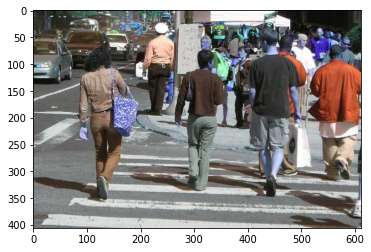

In [78]:
plt.imshow(img)
plt.show()

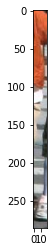

In [86]:
patch = get_patch(img, bboxes[4])
plt.imshow(patch)
plt.show()

In [19]:
bboxes

[[201.0, 83.0, 139.0, 282.0]]

In [6]:
x = 'PennFudanPed/PNGImages/PennPed00004.png'
x[-7:-4]

'004'